In [1]:
library(tidyverse)
library(glatos)


detections_path <- file.path('../data', 'detections.csv')
detections <- glatos::read_glatos_detections(detections_path)

detections <- glatos::false_detections(detections, tf = 3600)
filtered_detections <- detections %>% filter(passed_filter != FALSE)

detection_events <- glatos::detection_events(filtered_detections, location_col = 'station')
detection_events  

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

version 0.4.0 ('full-english-breakfast')

The filter identified 93 (1.3%) of 7180 detections as potentially false.

The event filter distilled 7087 detections down to 3537 distinct detection events.



event,animal_id,location,mean_latitude,mean_longitude,first_detection,last_detection,num_detections,res_time_sec
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<int>,<dbl>
1,153,TTB-002,43.39165,-83.99264,2012-04-29 01:48:37,2012-04-29 02:05:33,8,1016
2,153,TTB-001,43.38709,-83.98737,2012-04-29 02:08:00,2012-04-29 02:08:00,1,0
3,153,TTB-002,43.39165,-83.99264,2012-04-29 02:08:00,2012-04-29 02:08:00,1,0
4,153,TTB-001,43.38709,-83.98737,2012-04-29 02:09:50,2012-04-29 02:09:50,1,0
5,153,TTB-002,43.39165,-83.99264,2012-04-29 02:09:50,2012-04-29 02:09:50,1,0
6,153,TTB-001,43.38709,-83.98737,2012-04-29 02:12:24,2012-04-29 02:12:24,1,0
7,153,TTB-002,43.39165,-83.99264,2012-04-29 02:12:24,2012-04-29 02:12:24,1,0
8,153,TTB-001,43.38709,-83.98737,2012-04-29 02:14:27,2012-04-29 02:14:27,1,0
9,153,TTB-002,43.39165,-83.99264,2012-04-29 02:14:27,2012-04-29 02:14:27,1,0


In [2]:
library(lubridate)

detection_events <- 
    detection_events %>% 
    mutate(detection_interval = lubridate::interval(first_detection, last_detection))

detection_events


Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date




event,animal_id,location,mean_latitude,mean_longitude,first_detection,last_detection,num_detections,res_time_sec,detection_interval
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<int>,<dbl>,<Interval>
1,153,TTB-002,43.39165,-83.99264,2012-04-29 01:48:37,2012-04-29 02:05:33,8,1016,2012-04-29 01:48:37 UTC--2012-04-29 02:05:33 UTC
2,153,TTB-001,43.38709,-83.98737,2012-04-29 02:08:00,2012-04-29 02:08:00,1,0,2012-04-29 02:08:00 UTC--2012-04-29 02:08:00 UTC
3,153,TTB-002,43.39165,-83.99264,2012-04-29 02:08:00,2012-04-29 02:08:00,1,0,2012-04-29 02:08:00 UTC--2012-04-29 02:08:00 UTC
4,153,TTB-001,43.38709,-83.98737,2012-04-29 02:09:50,2012-04-29 02:09:50,1,0,2012-04-29 02:09:50 UTC--2012-04-29 02:09:50 UTC
5,153,TTB-002,43.39165,-83.99264,2012-04-29 02:09:50,2012-04-29 02:09:50,1,0,2012-04-29 02:09:50 UTC--2012-04-29 02:09:50 UTC
6,153,TTB-001,43.38709,-83.98737,2012-04-29 02:12:24,2012-04-29 02:12:24,1,0,2012-04-29 02:12:24 UTC--2012-04-29 02:12:24 UTC
7,153,TTB-002,43.39165,-83.99264,2012-04-29 02:12:24,2012-04-29 02:12:24,1,0,2012-04-29 02:12:24 UTC--2012-04-29 02:12:24 UTC
8,153,TTB-001,43.38709,-83.98737,2012-04-29 02:14:27,2012-04-29 02:14:27,1,0,2012-04-29 02:14:27 UTC--2012-04-29 02:14:27 UTC
9,153,TTB-002,43.39165,-83.99264,2012-04-29 02:14:27,2012-04-29 02:14:27,1,0,2012-04-29 02:14:27 UTC--2012-04-29 02:14:27 UTC


In [3]:
for(event in detection_events$event) {
    detection_events$overlaps_with[event] = paste( # We use paste to create a string of other events
        which(detection_events$location == detection_events$location[event] &  # Make sure that the location is the same
            detection_events$event != event &  # Make sure the event is not the same
            lubridate::int_overlaps(detection_events$detection_interval[event], detection_events$detection_interval) 
            # We can use lubridate's int_overlaps function to find the overlapping events
        ),
        collapse=",")
}

detection_events


event,animal_id,location,mean_latitude,mean_longitude,first_detection,last_detection,num_detections,res_time_sec,detection_interval,overlaps_with
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<int>,<dbl>,<Interval>,<chr>
1,153,TTB-002,43.39165,-83.99264,2012-04-29 01:48:37,2012-04-29 02:05:33,8,1016,2012-04-29 01:48:37 UTC--2012-04-29 02:05:33 UTC,
2,153,TTB-001,43.38709,-83.98737,2012-04-29 02:08:00,2012-04-29 02:08:00,1,0,2012-04-29 02:08:00 UTC--2012-04-29 02:08:00 UTC,
3,153,TTB-002,43.39165,-83.99264,2012-04-29 02:08:00,2012-04-29 02:08:00,1,0,2012-04-29 02:08:00 UTC--2012-04-29 02:08:00 UTC,
4,153,TTB-001,43.38709,-83.98737,2012-04-29 02:09:50,2012-04-29 02:09:50,1,0,2012-04-29 02:09:50 UTC--2012-04-29 02:09:50 UTC,
5,153,TTB-002,43.39165,-83.99264,2012-04-29 02:09:50,2012-04-29 02:09:50,1,0,2012-04-29 02:09:50 UTC--2012-04-29 02:09:50 UTC,
6,153,TTB-001,43.38709,-83.98737,2012-04-29 02:12:24,2012-04-29 02:12:24,1,0,2012-04-29 02:12:24 UTC--2012-04-29 02:12:24 UTC,
7,153,TTB-002,43.39165,-83.99264,2012-04-29 02:12:24,2012-04-29 02:12:24,1,0,2012-04-29 02:12:24 UTC--2012-04-29 02:12:24 UTC,
8,153,TTB-001,43.38709,-83.98737,2012-04-29 02:14:27,2012-04-29 02:14:27,1,0,2012-04-29 02:14:27 UTC--2012-04-29 02:14:27 UTC,
9,153,TTB-002,43.39165,-83.99264,2012-04-29 02:14:27,2012-04-29 02:14:27,1,0,2012-04-29 02:14:27 UTC--2012-04-29 02:14:27 UTC,


In [4]:
detection_events %>% 
    select(-one_of("detection_interval")) %>% 
    filter(detection_events$overlaps_with != '')  

event,animal_id,location,mean_latitude,mean_longitude,first_detection,last_detection,num_detections,res_time_sec,overlaps_with
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<int>,<dbl>,<chr>
1513,22,MAU-003,41.57612,-83.61071,2012-03-27 17:42:08,2012-03-27 21:02:42,13,12034,"3264,3268,3272,3276,3280,3282,3284,3287,3290,3293,3296,3300,3302,3305,3308,3311,3313,3315,3317,3319,3323,3325,3327,3331,3334,3337,3340,3342"
1530,22,MAU-011,41.63532,-83.53083,2012-04-04 21:20:18,2012-04-04 21:20:18,1,0,3400
1532,22,MAU-011,41.63532,-83.53083,2012-04-04 21:25:20,2012-04-04 21:25:20,1,0,3400
1534,22,MAU-011,41.63532,-83.53083,2012-04-04 21:27:53,2012-04-04 21:27:53,1,0,3400
1536,22,MAU-011,41.63532,-83.53083,2012-04-04 21:29:54,2012-04-04 21:29:54,1,0,3400
1538,22,MAU-011,41.63532,-83.53083,2012-04-04 21:32:26,2012-04-04 21:32:26,1,0,3400
1540,22,MAU-011,41.63532,-83.53083,2012-04-04 21:40:52,2012-04-04 21:55:53,10,901,3400
1542,22,MAU-011,41.63532,-83.53083,2012-04-04 21:57:40,2012-04-04 22:03:03,4,323,3400
1544,22,MAU-011,41.63532,-83.53083,2012-04-04 22:05:45,2012-04-04 22:05:45,1,0,3400


In [5]:
summary_data <- 
    detection_events %>% 
    group_by(location) %>% 
    summarise(detection_count = sum(num_detections),
              num_unique_tags = n_distinct(animal_id),
              total_residence_time_in_seconds = sum(detection_interval),
              latitude = mean(mean_latitude),
              longitude = mean(mean_longitude))  

summary_data

location,detection_count,num_unique_tags,total_residence_time_in_seconds,latitude,longitude
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
DRF-004,62,1,13685,42.24937,-83.11824
DRL-004,61,1,13699,42.12746,-83.11873
DRL-010,83,1,13797,42.07690,-83.12096
DRL-011,42,1,9399,42.09637,-83.11681
DRU-001,7,1,201,42.35693,-82.93016
DRU-002,23,1,5549,42.35278,-82.92844
DRU-004,7,1,434,42.35469,-82.94291
DRU-005,28,1,4045,42.35085,-82.93774
DRU-006,4,1,398,42.34447,-82.93849


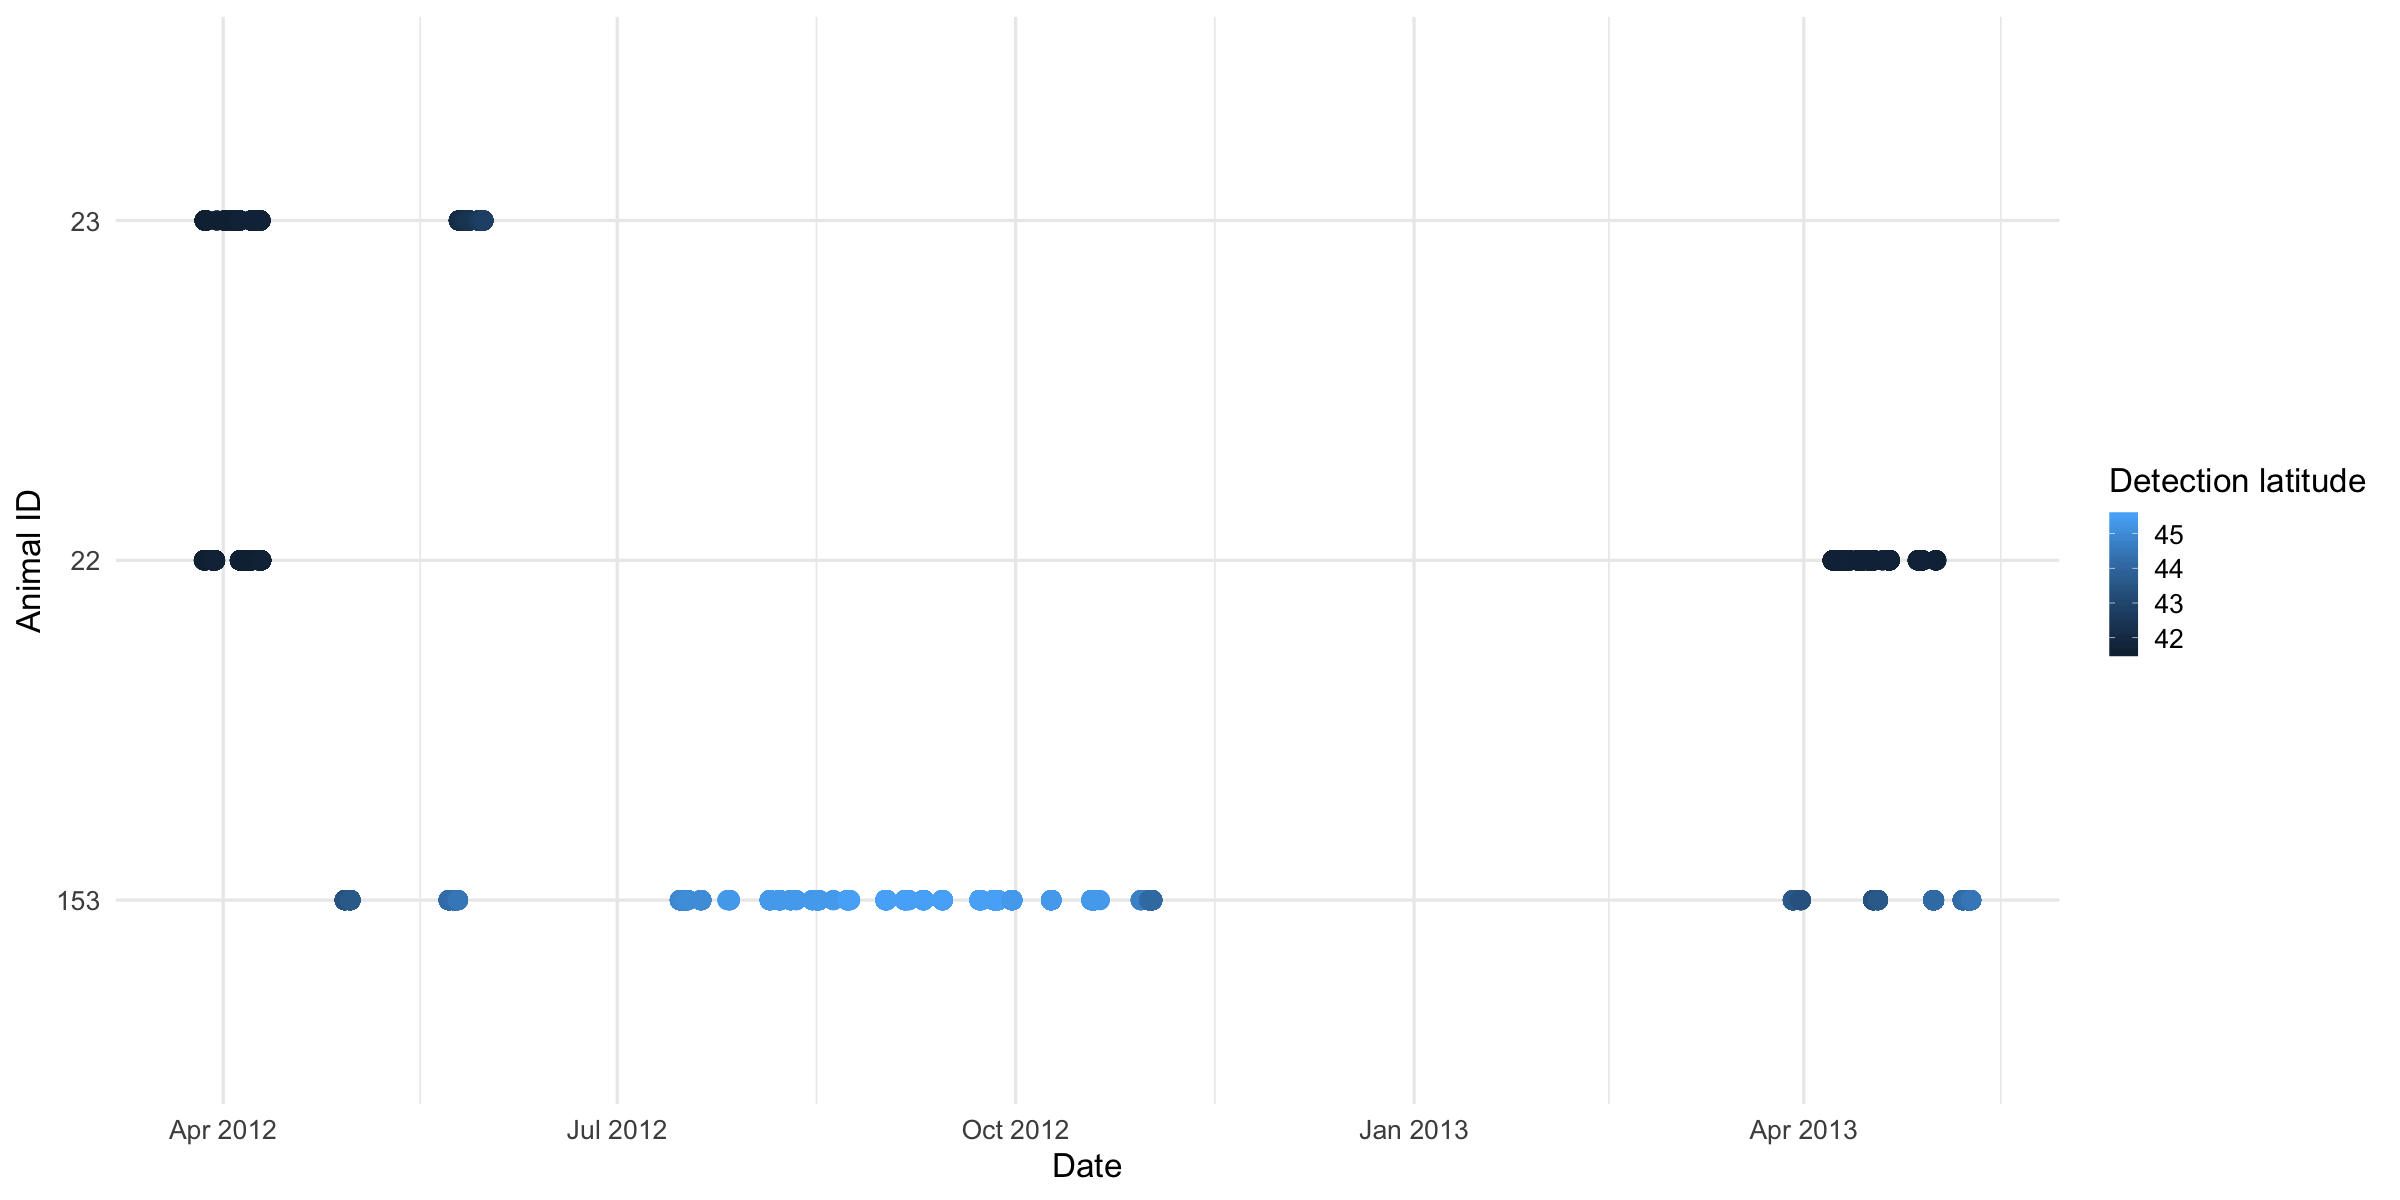

In [27]:
library(plotly)

abacus_plot <-
    filtered_detections %>% 
    filter(!str_detect(station, "lost")) %>% 
    ggplot(aes(x = detection_timestamp_utc, y = animal_id, color = deploy_lat)) +
    geom_point(size=5) +
    ylab("Animal ID") + xlab("Date") + labs(color = "Detection latitude") +
    theme_minimal(base_size = 20, base_family = "", base_rect_size = 60)

#Jupyter Notebook users: use this to resize your plot.
#options(repr.plot.width=20, repr.plot.height=10)
## Static plot
abacus_plot

In [ ]:
## Interactive plot using plotly
ggplotly(abacus_plot)

In [ ]:
geo <- list(
  #   scope = 'north america',
  showland = TRUE,
  landcolor = toRGB("#7BB992"),
  showocean = TRUE,
  oceancolor = toRGB("#A0AAB4"),
  showrivers = TRUE,
  rivercolor = toRGB("#A0AAB4"),
  showlakes = TRUE,
  lakecolor = toRGB("#A0AAB4"),
  showcountries = TRUE,
  resolution = 50,
  center = list(lat = ~median(latitude),
                lon = ~median(longitude)),
  lonaxis = list(range=c(~min(longitude) - 4, ~max(longitude) + 4)),
  lataxis = list(range=c(~min(latitude) - 4, ~max(latitude) + 4))
)

In [ ]:
map <- summary_data %>%
    filter(!str_detect(location, "lost")) %>%
    plot_geo(lat = ~latitude, lon = ~longitude, color = ~detection_count, height = 900 )%>%
    add_markers(
        text = ~paste(location, ': ', detection_count,'detections', ' & ', total_residence_time_in_seconds, ' seconds of residence time'),
        hoverinfo = "text",
        size = ~c(detection_count/10)#  + total_residence_time_in_seconds/3600)
    )%>%
    layout(title = "Detections in the Great Lakes", geo = geo)


map  

In [ ]:
Sys.setenv('MAPBOX_TOKEN' = 'pk.eyJ1IjoiYnJ1Y2VkIiwiYSI6ImNrM2Z6NDNscjBhNGYza3AzcW1pZnp3cDQifQ.kQLCJJtGcfX7mvq-wNkr2Q')
#require(devtools)
#install_version("plotly", version = "4.9.0", repos = "http://cran.us.r-project.org")


In [ ]:
mapbox <- summary_data %>%
  filter(!str_detect(location, "lost")) %>%
  plot_mapbox(lat = ~latitude, lon = ~longitude, color = ~detection_count , height = 900) %>%
  add_markers(
    text = ~paste(location, ': ', detection_count,'detections', ' & ', total_residence_time_in_seconds, ' seconds of residence time'),
    hoverinfo = "text",
    size = ~c(detection_count/10  + total_residence_time_in_seconds/3600)
  )%>%
  layout( mapbox = list(zoom = 7,
                        center = list(lat = ~median(latitude),
                                      lon = ~median(longitude))
  ))

mapbox

In [7]:
?aes